## TEXT CLASSIFICATION
#### QUESTIONNAIRE CLASSIFICATION NOTEBOOK
#### USING KNN ALGORITHM TO CLASSIFY THE TEXT


## IMPORTING LIBRARIES¶

In [1]:
import os
import re
import MeCab
import pickle
import gensim
import ast
import lda
import numpy as np
import pandas as pd
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import gensim.corpora as corpora
from gensim import similarities 
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
import spacy
from pprint import pprint
import warnings
import logging
from google.cloud import storage as gcs
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import PCA, TruncatedSVD, LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, classification_report, confusion_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, RandomizedSearchCV, GridSearchCV, ShuffleSplit
from scipy.spatial.distance import pdist, squareform
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
from collections import Counter
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
%matplotlib inline

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from google.protobuf.pyext import _message


## IMPORTING DATASET FROM GCS
#### THIS DATASET IS REFERED TO THE HAND-LABEL OVERALL SATISFACTION REASON FROM QUESTIONNAIRES

In [2]:
INPUT_BUCKET = 'gs://jesseulundo-bucket/questionnaire_classification/input_data/'
PROJECT_NAME = 'linkbal-dp'
BUCKET_NAME = 'mj-labeling-questionnaires-dev.datasets.linkbal.com' 
client = gcs.Client(PROJECT_NAME)
bucket = gcs.Bucket(client, name=BUCKET_NAME)
# JAPANESE STOPWORDS
jp_stop_words = pd.read_csv('gs://jesseulundo-bucket/questionnaire_classification/input_data/Japanese_stopword_list.txt', header=None, delimiter="\t")
# LABELLED QUESTIONNAIRE DATA HAND LABEL
qs = pd.read_csv(INPUT_BUCKET + 'ov_sat_cat_new.csv', sep=',')
qs

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning:

Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/

//anaconda3/en

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない
1233,117095,2,第3候補くらいまであると良い,その他


### CATEGORIES LABELLING

In [3]:
category_codes = {'スタッフの対応が悪い': 0, '会場や雰囲気が悪い': 1, '参加者の年齢が合っていない': 2, '参加人数が少ない': 3, '出会えなかった': 4, '飲食内容のが質が低い': 5, 'その他': 6}

## DATA CLEANING AND PRE-PROCESSING

In [4]:
# REMOVING EMPTY VALUES AND DUPLICATES
#qs = qs.drop(['want_recommend', 'want_recommend_reason'], axis=1)
qs = qs.dropna()
qs = qs.drop_duplicates() 
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない
1233,117095,2,第3候補くらいまであると良い,その他


In [5]:
# REMOVING POSITIVE QUESTIONNAIRES AND MEANINGLESS COMMENTS
qs = qs[qs.overall_satisfaction < 3]
qs = qs[qs.overall_satisfaction_reason != '上記同様']
qs = qs[qs.overall_satisfaction_reason != '同上']
qs = qs[qs.overall_satisfaction_reason != '上記と同じ']
qs = qs[qs.overall_satisfaction_reason != '上記のとおり。']
qs = qs[qs.overall_satisfaction_reason != '上記記載']
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い
...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない
1233,117095,2,第3候補くらいまであると良い,その他


### DATA DISTRIBUTION BY EACH CATEGORY

In [6]:
print(qs['categories'].value_counts())
qs_age = qs[qs.categories == '参加者の年齢が合っていない']
qs_staff = qs[qs.categories == 'スタッフの対応が悪い']
qs_num_att = qs[qs.categories == '参加人数が少ない']
qs_meet = qs[qs.categories == '出会えなかった']
qs_location = qs[qs.categories == '会場や雰囲気が悪い']
qs_food_drink = qs[qs.categories == '飲食内容のが質が低い']
qs_other = qs[qs.categories == 'その他']
print("CATEGORY DISTRIBUTION: ")
print("NUMBER OF QUESTIONNAIRES ABOUT AGE COMPLAINS: ", len(qs_age))
print("NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS: ", len(qs_staff))
print("NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS: ", len(qs_num_att))
print("NUMBER OF QUESTIONNAIRES ABOUT NO MATCH COMPLAINS: ", len(qs_meet))
print("NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAIN: ", len(qs_location))
print("NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAIN: ", len(qs_food_drink))
print("NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS: ", len(qs_other))

その他              377
参加人数が少ない         275
スタッフの対応が悪い       200
会場や雰囲気が悪い        149
飲食内容のが質が低い       113
出会えなかった           95
参加者の年齢が合っていない     20
Name: categories, dtype: int64
CATEGORY DISTRIBUTION: 
NUMBER OF QUESTIONNAIRES ABOUT AGE COMPLAINS:  20
NUMBER OF QUESTIONNAIRES ABOUT STAFF COMPLAINS:  200
NUMBER OF QUESTIONNAIRES ABOUT NUMBER OF PARTICIPANTS COMPLAINS:  275
NUMBER OF QUESTIONNAIRES ABOUT NO MATCH COMPLAINS:  95
NUMBER OF QUESTIONNAIRES ABOUT EVENT SPACE COMPLAIN:  149
NUMBER OF QUESTIONNAIRES ABOUT FOOD AND DRINK COMPLAIN:  113
NUMBER OF QUESTIONNAIRES ABOUT OTHER COMPLAINS:  377


### TOKENIZING AND STEMMING

In [7]:
# FUNCTION TO MAKE THE WORD IN IT'S NATURAL FORM AND TOKENIZE THE TEXT
tagger = MeCab.Tagger()
def tokenize_stemmer(text):
    lemmas = []
    for line in tagger.parse(text).splitlines()[:-1]:
        surface, feature = line.split('\t')
        if feature.split(',')[6] != '*':
            lemmas.append(feature.split(',')[6])
    return lemmas

In [8]:
# APPLYING THE FUNCTION TO EACH ROW OF THE QUESTIONNAIRE DATASET
qs['tokenized_overall_satisfaction_reason'] = qs.apply(lambda row: tokenize_stemmer(row['overall_satisfaction_reason']), axis=1)
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, の, 対応, が, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[他, の, の, お, 店, だ, と, 店員, や, 常連, さん, が, 気, を, ..."
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, する, て, いる, た, 人数, より, も, 少ない, 。]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, だ, のに, マンツーマン, 、, フリー, タイム, が, 少ない, 。]"
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, が, 酒, の, 肴, に, なる, ない]"
...,...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない,"[人数, が, 少ない, た, 。, あと, 集客, 目的, の, 人, が, 参加, する..."
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない,"[全て, において, 不満, 値段, も, 高い, 女の子, 少ない, 料理, 大して, 美..."
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない,"[開催, する, べし, だ, は, 人数, で, は, ない, です, う, か, ？, ..."
1233,117095,2,第3候補くらいまであると良い,その他,"[第, 候補, くらい, まで, ある, と, 良い]"


### REMOVING ALL STOPWORDS FROM THE TEXT

In [9]:
stop = jp_stop_words.values.tolist()
stop = [item for sublist in stop for item in sublist]
qs['tokenized_overall_satisfaction_reason'] = qs['tokenized_overall_satisfaction_reason'].apply(lambda x: [item for item in x if item not in stop])
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]"
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]"
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, 人数, 少ない]"
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]"
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, 酒, 肴]"
...,...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない,"[人数, 少ない, 集客, 目的, 参加, “, なつ, ”, という, 女性, 少, 人数..."
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない,"[全て, において, 不満, 値段, 高い, 女の子, 少ない, 料理, 大して, 美味い,..."
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない,"[開催, べし, 人数, また, 案内, 内容, 対, トーク, 好き, アーティスト, 記..."
1233,117095,2,第3候補くらいまであると良い,その他,"[候補, まで]"


### LABEL LOADING INTO DATAFRAME

In [10]:
qs['category_code'] = qs['categories']
qs = qs.replace({'category_code':category_codes})
qs

,id,overall_satisfaction,overall_satisfaction_reason,categories,tokenized_overall_satisfaction_reason,category_code
0,111377,2,店舗スタッフの対応が悪い,スタッフの対応が悪い,"[店舗, スタッフ, 対応, 悪い]",0
1,111379,2,他のボドゲのお店だと店員や常連さんが気をきかせてくれていたので、そこと比べてしまうとどうして...,スタッフの対応が悪い,"[店員, 常連, きかせる, 比べる, どうしても, 多い]",0
2,111381,2,想像していた人数よりも少ない。,参加人数が少ない,"[想像, 人数, 少ない]",3
3,111383,2,大人数なのにマンツーマン、フリータイムが少ない。,出会えなかった,"[大, 人数, マンツーマン, フリー, タイム, 少ない]",4
4,111386,2,食べ物が酒の肴にならない,飲食内容のが質が低い,"[食べ物, 酒, 肴]",5
...,...,...,...,...,...,...
1230,117061,2,人数が少なかった。\n\nあと集客目的の人が参加していた。\n“なつ”という女性は少人数の合...,参加人数が少ない,"[人数, 少ない, 集客, 目的, 参加, “, なつ, ”, という, 女性, 少, 人数...",3
1231,117070,1,全てにおいて不満\n値段も高い\n女の子少ない\n料理大して美味くない\nこのレベルなら二度...,参加人数が少ない,"[全て, において, 不満, 値段, 高い, 女の子, 少ない, 料理, 大して, 美味い,...",3
1232,117084,1,開催すべきでは人数ではないでしょうか？また、案内していた内容（2対2）でトーク。好きなアーテ...,参加人数が少ない,"[開催, べし, 人数, また, 案内, 内容, 対, トーク, 好き, アーティスト, 記...",3
1233,117095,2,第3候補くらいまであると良い,その他,"[候補, まで]",6


In [11]:
# PREPARE TEXT TO BE USED AS FEATURES FOR CLASSIFICATION
qs_new = qs[pd.notnull(qs['tokenized_overall_satisfaction_reason'])]
qs_new['tokenized_overall_satisfaction_reason'] = [' '.join(map(str, l)) for l in qs['tokenized_overall_satisfaction_reason']]
qs_new
print(qs_new['tokenized_overall_satisfaction_reason'])

0                                           店舗 スタッフ 対応 悪い
1                                 店員 常連 きかせる 比べる どうしても 多い
2                                               想像 人数 少ない
3                                 大 人数 マンツーマン フリー タイム 少ない
4                                                 食べ物 酒 肴
                              ...                        
1230    人数 少ない 集客 目的 参加 “ なつ ” という 女性 少 人数 合コン 開く ピン ハ...
1231       全て において 不満 値段 高い 女の子 少ない 料理 大して 美味い レベル 二度と 行く
1232    開催 べし 人数 また 案内 内容 対 トーク 好き アーティスト 記入 トーク 案内 違う...
1233                                                候補 まで
1234                      花火 見る 着く 順 自由 座る 出す 話す たり タイミング
Name: tokenized_overall_satisfaction_reason, Length: 1229, dtype: object


## TRAIN AND TEST SPLIT

In [12]:
X_train, X_test, y_train, y_test = train_test_split(qs_new['tokenized_overall_satisfaction_reason'], 
                                                    qs['category_code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

## PARAMETERS SELECTION

In [13]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [14]:
X_train = X_train.values.tolist()
X_train

['女性 人数 少ない 女性 満員 申し込み 終了',
 '店舗 スタッフ 対応 悪い',
 '開催',
 '担当 件 伝える 副業 よく 分かる 非常 不明瞭 不親切 記述 追加 料金 取る 騙す 思える',
 'トーク タイム 短い すぎる',
 '受付 スタッフ 交流 結構 ほったらかす',
 '通り',
 'サイト プロフィール カード 記入 記載',
 'ドリンク 絶対 頼む いける 書く 覚え ぐらい ドリンク チケット スタッフ 断る 「 取る 食事 なんか ルール 言う 疑問 浮かぶ 一応 趣味 コン 違う 婚 活 恋 活 相手 でも という なぜ 男女 金額 差 出る 来る 論理 かける',
 '食べ物 少ない',
 'イベント イベント 参加 決める 年齢 条件 不一致 参加 不愉快 身分 証明 提出 主催 側 確認 疑問 信頼 なくなる',
 'やる からには 電波 状況 考える',
 '人数 突破 実際 人数 かなり 相違',
 '自己 紹介 タイム 全然 盛る 上がれる ビール 杯 頼める 意味 分かる',
 '純粋 出会い 目的 来る',
 '最初 乾杯 だけ どうぞ 投げやり 適当',
 '着席 形式 応募 詐欺 街 信用 問う',
 'メッセージ カード 告白 タイム 記入 隣 座る 男性 見る 告白 タイム 紙 書ける 凄い 残念',
 '主催 利益',
 '参加 少ない ドリンク 食べ物 料金 釣り合う 男性 可哀想 レベル',
 '男性 参加 非常 少ない 人数 少ない 開催 取り止める イベント 案内 いただく',
 '料理 少ない',
 '二次会 値段 高い すぎる 個室 形式 もらう 聞こえる 希望 取る もらう',
 '料理 ドリンク 取る にくい 飲み物 だけ 終わる 案内 声 周り 音 消える 分かる くい 至近 距離 絶つ 周り 見える 動ける 参加 雰囲気 悪い 訳 無い けど 周り ずっと 居る 動く にくい',
 '人数 大きい 狭い',
 '初めて 参加 内容 常態 男女 調整 大変 サイト 女性 多い 男性 急募 内容 全く 逆 こんな 内容 勧める',
 '飲食 イベント 料理 ドリンク 提供 滞る 集中 出来る',
 '料理 品数 少ない 参加 人数 少ない 替え',
 '男女 比 どうにか',
 '

## TEXT REPRESENTATION AND FEATURE ENGINEERING
#### EXTRACTING IMPORTANTE FEATURES FROM THE TEXT TO BE USED BY THE MODEL

In [15]:
# IMPLEMENTING TF-IDF TO EXXTRACT MAIN FEATURES 
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)                        
features_train = tfidf.fit_transform(X_train)
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1044, 205)
(185, 205)


### REPRESENTATION OF MAIN WORDS (UNIGRAMS AND BIGRAMS) PER CATEGORY BASED ON THEIR FREQUENCY

In [16]:
for category, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' CATEGORY:".format(category))
    print(" MOST CORRELATED UNIGRAMS:\n. {}".format('\n. '.join(unigrams[-5:])))
    print(" MOST CORRELATED BIGRAMS:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'その他' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 通り
. スタッフ
. 人数
. 理由
. 少ない
 MOST CORRELATED BIGRAMS:
. 少ない すぎる
. 人数 少ない

# 'スタッフの対応が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 司会
. 受付
. 進行
. 運営
. スタッフ
 MOST CORRELATED BIGRAMS:
. 悪い すぎる
. スタッフ 対応

# '会場や雰囲気が悪い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. テーブル
. 部屋
. 場所
. 会場
. 狭い
 MOST CORRELATED BIGRAMS:
. 参加 人数
. 人数 少ない

# '出会えなかった' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 企画
. 話せる
. マッチング
. 替え
. 出会い
 MOST CORRELATED BIGRAMS:
. フリー タイム
. 連絡 交換

# '参加人数が少ない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 中止
. 男女
. 女性
. 人数
. 少ない
 MOST CORRELATED BIGRAMS:
. 参加 人数
. 人数 少ない

# '参加者の年齢が合っていない' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 記入
. 相手
. 印象
. 返金
. 年齢
 MOST CORRELATED BIGRAMS:
. お金 払う
. 男性 参加

# '飲食内容のが質が低い' CATEGORY:
 MOST CORRELATED UNIGRAMS:
. 食事
. 食べる
. 食べ物
. ご飯
. 料理
 MOST CORRELATED BIGRAMS:
. スタッフ 対応
. 料理 少ない



## SAVING THE FILES
#### INSERTING IMPORTANT INFORMATION IN FILES FOR FUTURE USAGE

In [17]:
# X_train
with open('/Users/jesse.ulundo/demo_tests/knn/X_train_KNN.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('/Users/jesse.ulundo/demo_tests/knn/X_test_KNN.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('/Users/jesse.ulundo/demo_tests/knn/y_train_KNN.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('/Users/jesse.ulundo/demo_tests/knn/y_test_KNN.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('/Users/jesse.ulundo/demo_tests/knn/df_qs_KNN.pickle', 'wb') as output:
    pickle.dump(qs, output)
    
# features_train
with open('/Users/jesse.ulundo/demo_tests/knn/features_train_KNN.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('/Users/jesse.ulundo/demo_tests/knn/labels_train_KNN.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('/Users/jesse.ulundo/demo_tests/knn/features_test_KNN.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('/Users/jesse.ulundo/demo_tests/knn/labels_test_KNN.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('/Users/jesse.ulundo/demo_tests/knn/tfidf_KNN.pickle', 'wb') as output:
    pickle.dump(tfidf, output)

In [18]:
# INSERTING THE FILES TO GCS BUCKETS 
#!gsutil -m cp *.pickle gs://jesseulundo-bucket/questionnaire_classification/train_and_test_data/

## MODEL DEVELOPMENT
### LOADING FILES THAT WERE SAVED ON THE PREVIOUS STEP

In [19]:
# Dataframe
path_df_qs = "/Users/jesse.ulundo/demo_tests/knn/df_qs_KNN.pickle"
with open(path_df_qs, 'rb') as data:
    df_qs_KNN = pickle.load(data)

# features_train
path_features_train = "/Users/jesse.ulundo/demo_tests/knn/features_train_KNN.pickle"
with open(path_features_train, 'rb') as data:
    features_train_KNN = pickle.load(data)

# labels_train
path_labels_train = "/Users/jesse.ulundo/demo_tests/knn/labels_train_KNN.pickle"
with open(path_labels_train, 'rb') as data:
    labels_train_KNN = pickle.load(data)

# features_test
path_features_test = "/Users/jesse.ulundo/demo_tests/knn/features_test_KNN.pickle"
with open(path_features_test, 'rb') as data:
    features_test_KNN = pickle.load(data)

# labels_test
path_labels_test = "/Users/jesse.ulundo/demo_tests/knn/labels_test_KNN.pickle"
with open(path_labels_test, 'rb') as data:
    labels_test_KNN = pickle.load(data)

In [20]:
print(features_train.shape)
print(features_test.shape)

(1044, 205)
(185, 205)


## MODEL TRAINING
### Cross-Validation for Hyperparameter tuning

In [21]:
knnc_0 = KNeighborsClassifier()
print('PARAMETERS CURRENTLY IN USE:\n')
pprint(knnc_0.get_params())

PARAMETERS CURRENTLY IN USE:

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


### Randomized Search Cross Validation

In [22]:
# Create the parameter grid 
n_neighbors = [int(x) for x in np.linspace(start = 1, stop = 220, num = 100)]

param_grid = {'n_neighbors': n_neighbors}

# Create a base model
knnc = KNeighborsClassifier()

# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(features_train_KNN, labels_train_KNN)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:    5.2s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 3, 5, 7, 9, 12, 14, 16, 18, 20, 23,
                                         25, 27, 29, 31, 34, 36, 38, 40, 43, 45,
                                         47, 49, 51, 54, 56, 58, 60, 62, 65, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

#### results from the Random Search:

In [23]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 211}

The mean accuracy of a model with these hyperparameters is:
0.5014492753623189


### Grid Search Cross Validation

In [24]:
n_neighbors = [1,2,3,4,5,6,7,8,9,10,11]
param_grid = {'n_neighbors': n_neighbors}

knnc = KNeighborsClassifier()
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)

grid_search = GridSearchCV(estimator=knnc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

grid_search.fit(features_train_KNN, labels_train_KNN)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 11 candidates, totalling 33 fits


[Parallel(n_jobs=1)]: Done  33 out of  33 | elapsed:    0.5s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=1)

#### best hyperparameters turn out to be:

In [25]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'n_neighbors': 6}

The mean accuracy of a model with these hyperparameters is:
0.44347826086956516


In [26]:
best_knnc = grid_search.best_estimator_
best_knnc

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

## Model fit and performance

In [27]:
best_knnc.fit(features_train_KNN, labels_train_KNN)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [28]:
knnc_pred = best_knnc.predict(features_test_KNN)

#### TRAINING ACCURACY

In [29]:
# Training accuracy
print("The training accuracy is: ")
print(accuracy_score(labels_train_KNN, best_knnc.predict(features_train_KNN)))

The training accuracy is: 
0.5775862068965517


#### TEST ACCURACY

In [30]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(labels_test_KNN, knnc_pred))

The test accuracy is: 
0.4486486486486487


#### CLASSIFICATION REPORT

In [31]:
# Classification report
print("Classification report")
print(classification_report(labels_test_KNN, knnc_pred))

Classification report
              precision    recall  f1-score   support

           0       0.56      0.26      0.35        35
           1       0.40      0.09      0.15        22
           2       1.00      0.25      0.40         4
           3       0.65      0.52      0.58        33
           4       0.33      0.16      0.21        19
           5       0.71      0.29      0.42        17
           6       0.38      0.84      0.52        55

    accuracy                           0.45       185
   macro avg       0.58      0.34      0.38       185
weighted avg       0.51      0.45      0.41       185



### CONFUSION MATRIX

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12473 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12479 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12483 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12501 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 12398 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning:

Glyph 23550 missing from current font.

//anaconda3/envs/jctensorflow/lib/python3.7/site-packages/matplotlib/b

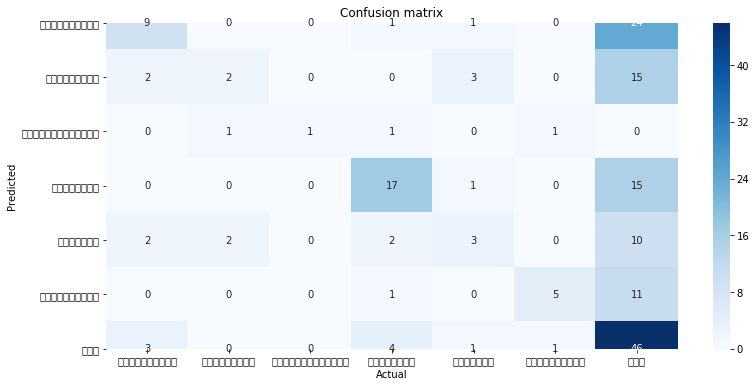

In [32]:
aux_df = df_qs_KNN[['categories', 'category_code']].drop_duplicates().sort_values('category_code')
conf_matrix = confusion_matrix(labels_test_KNN, knnc_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['categories'].values, 
            yticklabels=aux_df['categories'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

### RESULT

In [33]:
base_model = KNeighborsClassifier()
base_model.fit(features_train_KNN, labels_train_KNN)
accuracy_score(labels_test_KNN, base_model.predict(features_test_KNN))

0.4594594594594595

In [34]:
best_knnc.fit(features_train_KNN, labels_train_KNN)
accuracy_score(labels_test_KNN, best_knnc.predict(features_test_KNN))

0.4486486486486487

In [35]:
d = {
     'Model': 'KNN',
     'Training Set Accuracy': accuracy_score(labels_train_KNN, best_knnc.predict(features_train_KNN)),
     'Test Set Accuracy': accuracy_score(labels_test_KNN, knnc_pred)
}

df_models_knnc = pd.DataFrame(d, index=[0])
df_models_knnc

,Model,Training Set Accuracy,Test Set Accuracy
0,KNN,0.577586,0.448649


In [36]:
#with open('Models/best_knnc.pickle', 'wb') as output:
#    pickle.dump(best_knnc, output)

#with open('Models/df_models_knnc.pickle', 'wb') as output:
#    pickle.dump(df_models_knnc, output)